# 합성곱 신경망을 사용한 이미지 분류

이번 절에서는 케라스 API를 사용해 합성곱 신경망을 만듭니다. 케라스의 Conv2D 클래스를 사용해 32개의 필터와 64개의 필터를 둔 2개의 합성곱 층을 추가합니다.
두 합성곱 층 다음에는 모두 (2, 2) 크기의 최대 풀링 층을 배치합니다. 두 번쨰 풀링 층을 통과한 특성 맵을 펼친 다음 밀집 은닉층에 연결하고 최종적으로 10개의 뉴런을 가진 출력층에서 샘플에 대한 확률을 출력합니다.

조기 종료 기법을 사용해 모델을 훈련한 다음 검증 세트로 최적의 에포크에서 성능을 평가합니다. 샘플 데이터 하나를 선택해 예측 클래스를 출력합니다.

마지막으로 사용하지 않은 테스트 세트를 사용해 최종 모델의 일반화 성능을 평가합니다. 

## 핵심 패키지와 함수

**TensorFlow**

- **Conv2D**는 입력의 너비와 높이 방향의 합성곱 연산을 구현한 클래스입니다.

  첫 번째 매개변수는 합성곱 필터의 개수입니다.

  kernel_size 매개변수는 필터의 커널 크기를 지정합니다. 가로세로 크기가 같은 경우 정수 하나로, 다른 경우 정수의 튜플로 지정할 수 있습니다. 일반적으로 커널의 가로세로 크기는 동일합니다. 커널의 깊이는 입력의 깊이와 동일하기 때문에 따로 지정하지 않습니다.

  padding 매개변수는 입력의 패딩 타입을 지정합니다. 기본값 'valid'는 패딩을 하지 않습니다. 'same'은 합성곱 층의 출력의 가로세로 크기를 입력과 동일하게 맞추도록 입력에 패딩을 추가합니다.

- **MaxPooling2D**는 입력의 너비와 높이를 줄이는 풀링 연산을 구현한 클래스입니다. 

  첫 번째 매개변수는 풀링의 크기를 지정하며, 가로세로 크기가 같은 경우 정수 하나로, 다른 경우 정수의 튜플로 지정할 수 있습니다. 일반적으로 풀링의 가로세로 크기는 같게 지정합니다. 

- **plot_model()**은 케라스 모델 구조를 주피터 노트북에 그리거나 파일을 저장합니다.

  첫 번째 매개변수에 케라스 모델 객체를 전달합니다.

  to_file 매개변수에 파일 이름을 지정하면 그림을 파일로 저장합니다.

  show_shapes 매개변수를 True로 지정하면 층의 입력, 출력 크기를 표시합니다. 기본값은 False입니다.
   

## 패션 MNIST 데이터 불러오기

케라스 API를 사용해 데이터를 불러오고 전처리합니다. 데이터 스케일을 0-255 사이에서 0-1 사이로 바꾸고 훈련 세트와 검증 세트로 나눕니다.

입력 이미지는 항상 깊이(채널) 차원이 있어야 합니다. Conv2D 층을 사용하기 위해 마지막에 이 채널 차원을 추가합니다.

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0 # 넘파이 reshape() 메서드를 사용해 (전체 배열 차원을 그대로 유지하면서) 마지막에 깊이(채널) 차원을 추가

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

(이제 (48000, 28, 28) 크기인 train_input이 (48000, 28, 28, 1) 크기인 train_scaled가 되었습니다.)

## 합성곱 신경망 만들기

Sequential 클래스의 객체를 만들고 **첫 번째 합성곱 층인 Conv2D를 추가**합니다. 이 클래스는 다른 층 클래스와 마찬가지로 keras.layers 패키지 아래에 있습니다. 여기에서는 이전 장에서 보았던 모델의 add() 메서드를 사용해 층을 하나씩 차례대로 추가하겠습니다. 

In [ ]:
model = keras.Sequential()

In [ ]:
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                              padding='same', input_shape=(28,28,1))) # (3, 3, 1) 필터 32개

이 합성곱 층은 32개의 필터를 사용합니다. 커널의 크기는 (3, 3)이고 렐루 활성화 함수와 세임 패딩을 사용합니다.

케라스 신경망 모델의 첫 번째 층에서 입력의 차원을 지정해 주어야 합니다. 앞서 패션 MNIST 이미지를 (28, 28)에서 (28, 28, 1)로 변경했던 것을 기억하시죠? input_shape 매개변수를 이 값으로 지정합니다.

In [ ]:
model.add(keras.layers.MaxPooling2D(2)) # (2, 2) 최대 풀링

풀링 층을 추가하였습니다. 케라스는 최대 풀링과 평균 풀링을 keras.layers 패키지 아래 MaxPooling2D와 AveragePooling2D 클래스로 제공합니다. 전형적인 풀링 크기인 (2, 2) 풀링을 사용하였습니다. Conv2D 클래스의 kernel_size처럼 가로세로 크기가 같으면 정수 하나로 지정할 수 있습니다.

패션 MNIST 이미지가 (28, 28) 크기에 세임 패딩을 적용했기 때문에 합성곱 층에서 출력된 특성 맵의 가로세로 크기는 입력과 동일합니다.

그다음 (2, 2) 풀링을 적용했으므로 특성 맵의 크기느 절반으로 줄어듭니다. 합성곱 층에서 32개의 필터를 사용했기 때문에 이 특성 맵의 깊이는 32가 됩니다. 따라서 최대 풀링을 통과한 특성 맵의 크기는 (14, 14, 32)가 됩니다.

In [ ]:
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', 
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))

두 번째 합성곱-풀링 층은 첫 번째와 거의 동일합니다. 필터의 개수를 64개로 늘린 점만 다릅니다.

최종적으로 만들어지는 특성 맵의 크기는 (7, 7, 64)가 됩니다.

**이제 Flatten 클래스로 3차원 특성 맵을 일렬로 펼칠 차례입니다. 이렇게 하는 이유는 마지막에 10개의 뉴런을 가진 출력층에서 확률을 계산하기 때문입니다.** 여기에서는 특성 맵을 일렬로 펼쳐서 바로 출력층에 전달하지 않고 중간에 하나의 밀집 은닉층을 하나 더 두도록 하겠습니다.

In [ ]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu')) # 은닉층: 100개의 뉴런 사용하고 활성화 함수는 렐루 함수를 사용
model.add(keras.layers.Dropout(0.4)) # 드롭아웃 층: 하이퍼파라미터 40% = 뉴런의 활동 40% 정지 = 은닉층의 과대적합을 막아 성능 개선
model.add(keras.layers.Dense(10, activation='softmax')) # 출력층: 패션 MNIST 데이터셋은 클래스 10개를 분류하는 다중 분류 문제이므로 마지막 층의 활성화 함수는 소프트맥스를 사용

케라스 모델의 구성을 마쳤으니 summary() 메서드로 모델 구조를 출력해 보겠습니다.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

conv2d_1 (Conv2D)
- Output Shape: None, 14, 14, 64(배치차원, 높이, 너비, 깊이)
- Param(파라미터): 18496(3 X 3 X 32 X 64 + 64)개의 가중치

flatten (Flatten)
- Output Shape: None, 3136((7, 7, 64) 크기의 특성 맵을 1차원 배열로 펼침)

dense (Dense)   
- Param(파라미터): 313700(3136 X 100 + 100)개의 가중치    


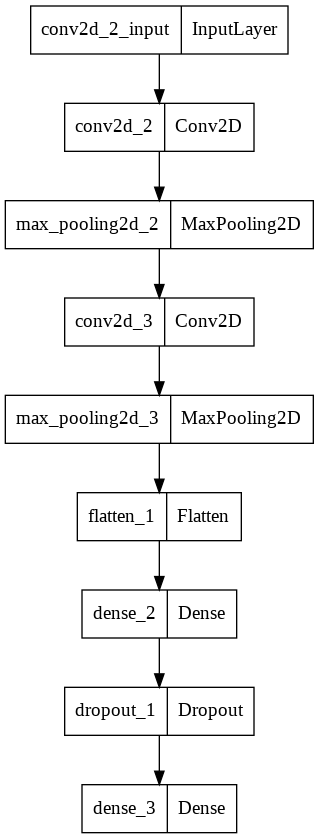

In [ ]:
keras.utils.plot_model(model)

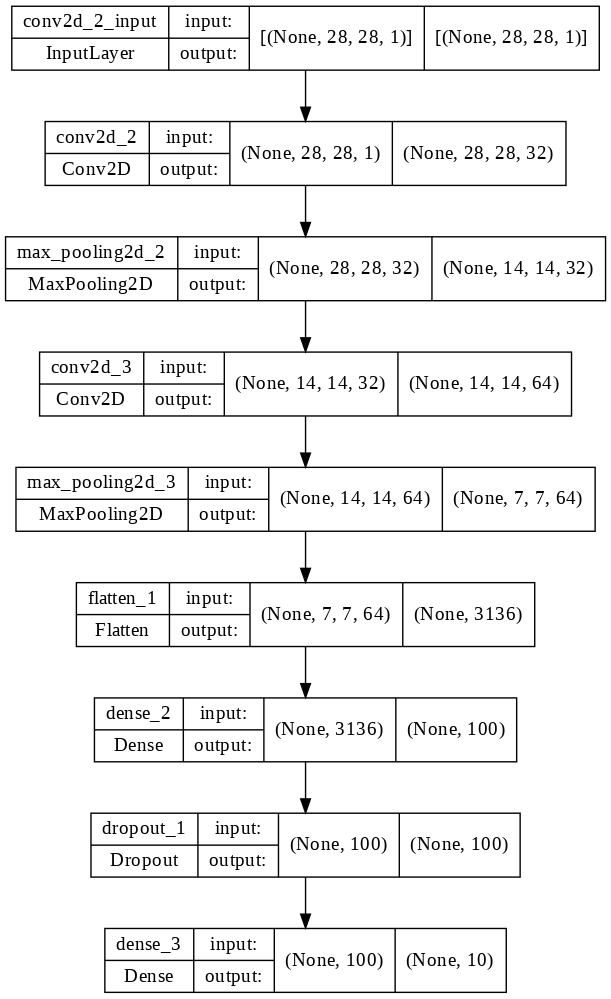

In [ ]:
keras.utils.plot_model(model, show_shapes=True, to_file='cnn-architecture.png', # show_shapes 매개변수를 True로 설정하면 이 그림에 입력과 출력의 크기 표시
                       dpi=100) # dpi 매개변수로 해상도를 지정

## 모델 컴파일과 훈련

**7장 3절 참조**

In [ ]:
model.compile(optimizer='adam', # Adam은 적응적 학습률을 사용하기 때문에 에포크가 진행되면서 학습률의 크기를 조정
              loss='sparse_categorical_crossentropy', # 타깃값이 정수 레이블이므로 
              metrics='accuracy')
# 콜백은 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', # ModelCheckpoint은 기본적으로 에포크마다 모델을 저장
                                                save_best_only=True) # 가장 낮은 검증 점수를 만드는 모델을 저장
# 조기 종료는 과대적합이 시작되기 전에 훈련 에포크 횟수를 제한하는 역할                                                
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, # 2번 연속 검증 점수가 향상되지 않으면 훈련은 중지
                                                  restore_best_weights=True) # 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌림

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 73s 48ms/step - loss: 0.5477 - accuracy: 0.8026 - val_loss: 0.3435 - val_accuracy: 0.8716
Epoch 2/20
1500/1500 [==============================] - 65s 44ms/step - loss: 0.3682 - accuracy: 0.8710 - val_loss: 0.2922 - val_accuracy: 0.8915
Epoch 3/20
1500/1500 [==============================] - 65s 43ms/step - loss: 0.3166 - accuracy: 0.8862 - val_loss: 0.2748 - val_accuracy: 0.8964
Epoch 4/20
1500/1500 [==============================] - 64s 42ms/step - loss: 0.2829 - accuracy: 0.8991 - val_loss: 0.2479 - val_accuracy: 0.9066
Epoch 5/20
1500/1500 [==============================] - 65s 43ms/step - loss: 0.2588 - accuracy: 0.9066 - val_loss: 0.2374 - val_accuracy: 0.9136
Epoch 6/20
1500/1500 [==============================] - 64s 42ms/step - loss: 0.2379 - accuracy: 0.9131 - val_loss: 0.2338 - val_accuracy: 0.9135
Epoch 7/20
1500/1500 [==============================] - 66s 44ms/step - loss: 0.2199 - accuracy: 0.9206 - val_loss: 0.2259 -

In [ ]:
import matplotlib.pyplot as plt

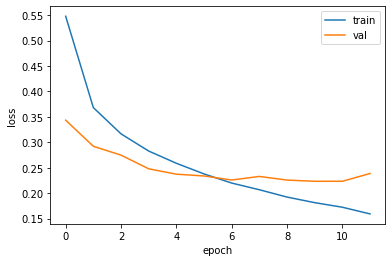

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 9번째 epoch 훈련 종료
- 7번째 epoch 최적(가장 낮은 손실 기록) 이후 과대적합 epoch 2회 이상 발생 조기 종료 

In [ ]:
model.evaluate(val_scaled, val_target) # 검증 세트에 대한 성능을 평가

375/375 [==============================] - 5s 12ms/step - loss: 0.2234 - accuracy: 0.9211


[0.22340920567512512, 0.9210833311080933]

이 결과는 fit() 메서드의 출력 중 7번째 에포크의 출력과 동일합니다. EarlyStopping 콜백이 model 객체를 최상의 모델 파라미터로 잘 복원한 것 같습니다.

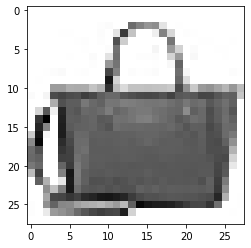

In [ ]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

여기에서는 편의상 검증 세트의 첫 번째 샘플을 처음 본 이미지라고 가정합니다.맷플롯립에서는 흑백 이미지에 깊이 차원은 없습니다. 따라서 (28, 28, 1) 크기를 (28, 28)로 바꾸어 출력해야 합니다.



In [ ]:
preds = model.predict(val_scaled[0:1]) # 배열 슬라이싱은 인덱싱과 다르게 선택된 원소가 하나이더라도 전체 차원이 유지되어 (1, 28, 28, 1) 크기를 만듦
print(preds)

[[3.58283306e-22 1.23190175e-26 7.48376132e-26 2.29298890e-24
  5.55543022e-21 1.90756153e-20 2.53087088e-20 2.11210925e-25
  1.00000000e+00 2.06872406e-31]]


출력값 중에서 e 문자는 지수 표현을 의미합니다. 예를 들어 5e3은 5 X $10^3$이고 5e-3은 5 X $10^{-3}$입니다.

출력 결과를 보면 아홉 번째 값이 1이고 다른 값은 거의 0에 가깝습니다.

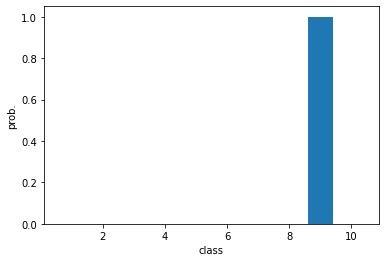

In [ ]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [ ]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [ ]:
import numpy as np
print(classes[np.argmax(preds)])

가방


훈련 세트와 검증 세트에서 했던 것처럼 픽셀값의 범위를 0-1 사이로 바꾸고 이미지 크기를 (28, 28)에서 (28, 28, 1)로 바꾸겠습니다.

In [ ]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

그다음 evaluate() 메서드로 테스트 세트에 대한 성능을 측정합니다.

In [ ]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 4s 13ms/step - loss: 0.2498 - accuracy: 0.9125


[0.2498273253440857, 0.9125000238418579]

역시 예상대로 테스트 세트에서의 점수는 검증 세트보다 조금 더 작습니다. 이 모델을 실전에 투입하여 패션 아이템을 분류하단다면 약 91%의 성능을 기대할 수 있습니다.